In [ ]:
import os,re,string,nltk,operator,math,tqdm
import numpy as np
import pandas as pd
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer

#SHOULD I USE LogisticRegressionCV???
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, plot_confusion_matrix, f1_score, precision_score, recall_score
from matplotlib import pyplot as plt

#data augmentation
!pip install googletrans==4.0.0-rc1
from googletrans import Translator

In [10]:
df = pd.read_csv('tweets.csv')
df = df[['tweet', 'sarcastic']]
df.head()

,tweet,sarcastic
0,The only thing I got from college is a caffein...,1
1,I love it when professors draw a big question ...,1
2,Remember the hundred emails from companies whe...,1
3,Today my pop-pop told me I was not “forced” to...,1
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1


In [11]:
df[df.isnull().any(axis=1)]
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3467 entries, 0 to 3467
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      3467 non-null   object
 1   sarcastic  3467 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 81.3+ KB


In [12]:
def remove_punctuations(text:str)->str: 
  return  "".join(char for char in text if char not in string.punctuation)
  

def clean_tweet(text:str)->str:
  '''Should remove hashtags and mentions first before removing punctuations'''
  # remove mentions
  text = re.sub('@[A-Za-z0-9_]+', '', text)

  # remove hashtags
  text = re.sub('#[A-Za-z0-9_]+','', text)

  # remove links
  text = re.sub(r"www.\S+", "", text)
  text = re.sub(r"http\S+", "", text)
  
  # remove the punctuations in text from string.punctuation
  text  = remove_punctuations(text)

  # filter only alphanumeric characters except whitespaces
  text = re.sub("[^A-Za-z0-9\s]","", text)
  
  # replace consecutive whitespace with single space
  text = re.sub('\s+', ' ', text)
  return text

def tokenization(cleaned_text:str)->list:
    cleaned_text = re.split('\W+', cleaned_text)
    cleaned_text = list(filter(None, cleaned_text)) #removes empty list element
    return cleaned_text

def remove_stopwords(tokenized_text:list)->list:

    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.remove('no')# No and Not is important in sarcasm??
    stopwords.remove('not')

    stopwords = [remove_punctuations(word) for word in stopwords]
    tokenized_text = [word for word in tokenized_text if word.lower() not in stopwords]
    return tokenized_text

''' Should I use these??
  def stemming(text)

  def lemmatizer(text)
'''

' Should I use these??\n  def stemming(text)\n\n  def lemmatizer(text)\n'

In [13]:
df['tweet_cleaned'] = df['tweet'].apply(lambda x: clean_tweet(x))
df['tweet_tokenized'] = df['tweet_cleaned'].apply(lambda x:tokenization(x))
df['tweet_no_stopwords'] = df['tweet_tokenized'].apply(lambda x:remove_stopwords(x))
print(df.sarcastic.value_counts())
df

0    2600
1     867
Name: sarcastic, dtype: int64


,tweet,sarcastic,tweet_cleaned,tweet_tokenized,tweet_no_stopwords
0,The only thing I got from college is a caffein...,1,The only thing I got from college is a caffein...,"[The, only, thing, I, got, from, college, is, ...","[thing, got, college, caffeine, addiction]"
1,I love it when professors draw a big question ...,1,I love it when professors draw a big question ...,"[I, love, it, when, professors, draw, a, big, ...","[love, professors, draw, big, question, mark, ..."
2,Remember the hundred emails from companies whe...,1,Remember the hundred emails from companies whe...,"[Remember, the, hundred, emails, from, compani...","[Remember, hundred, emails, companies, Covid, ..."
3,Today my pop-pop told me I was not “forced” to...,1,Today my poppop told me I was not forced to go...,"[Today, my, poppop, told, me, I, was, not, for...","[Today, poppop, told, not, forced, go, college..."
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I did too and I also reported Cancun Cruz not...,"[I, did, too, and, I, also, reported, Cancun, ...","[also, reported, Cancun, Cruz, not, worrying, ..."
...,...,...,...,...,...
3463,The population spike in Chicago in 9 months is...,0,The population spike in Chicago in 9 months is...,"[The, population, spike, in, Chicago, in, 9, m...","[population, spike, Chicago, 9, months, ridicu..."
3464,You'd think in the second to last English clas...,0,Youd think in the second to last English class...,"[Youd, think, in, the, second, to, last, Engli...","[think, second, last, English, class, year, pr..."
3465,I’m finally surfacing after a holiday to Scotl...,0,Im finally surfacing after a holiday to Scotla...,"[Im, finally, surfacing, after, a, holiday, to...","[Im, finally, surfacing, holiday, Scotland, di..."
3466,Couldn't be prouder today. Well done to every ...,0,Couldnt be prouder today Well done to every st...,"[Couldnt, be, prouder, today, Well, done, to, ...","[prouder, today, Well, done, every, student, g..."


In [26]:
#Data Augmentation (We have imbalanced data: Sarcastic -> 867, Non-sarcastic -> 2600)

def data_augmentation(sequence, aug_range=1, PROB = 1):
    languages = ['en', 'fr', 'th', 'tr', 'ur', 'ru', 'bg', 'de', 'ar', 'zh-cn', 'hi',
                 'sw', 'vi', 'es', 'el']

    augmented_tweets = []

    #instantiate translator
    translator = Translator()
    
    #store original language so we can convert back
    org_lang = translator.detect(sequence).lang
    
    for i in range(0,aug_range):
      #randomly choose language to translate sequence to  
      random_lang = np.random.choice([lang for lang in languages if lang is not org_lang])
      
      if org_lang in languages:
          #translate to new language and back to original
          translated = translator.translate(sequence, dest = random_lang).text
          #translate back to original language
          translated_back = translator.translate(translated, dest = org_lang).text
      
          #apply with certain probability
          if np.random.uniform(0, 1) <= PROB:
              output_sequence = translated_back
          else:
              output_sequence = sequence
          
          augmented_tweets.append(output_sequence)
          
      #if detected language not in our list of languages, do nothing
      else:
          augmented_tweets.append(sequence)
    
    return augmented_tweets

#check performance
for i in range(5):
    output = data_augmentation("The only thing I got from college is a caffeine addiction")
    print(output)

The only thing I got from college is a caffeine addiction
The only thing I got from university is a caffeine addiction.
The only thing I received from the college is to stick to caffeine.
The only thing I got from the college is a caffeine
The only thing I got from college is a caffeine addiction


In [23]:
# Get max intent count to match other minority classes through data augmentation
intent_count = df.sarcastic.value_counts().to_dict()
max_intent_count = max(intent_count.items(), key=operator.itemgetter(1))[1]
max_intent_count

2600

In [27]:
## Loop to interate all messages

newdf = pd.DataFrame()
for intent, count in intent_count.items() :
    count_diff = max_intent_count - count    ## Difference to fill
    multiplication_count = math.ceil((count_diff)/count)  ## Multiplying a minority classes for multiplication_count times
    if (multiplication_count) :
        old_message_df = pd.DataFrame()
        new_message_df = pd.DataFrame()
        for message in tqdm.tqdm(df[df["sarcastic"] == intent]["tweet"]) :
            ## Extracting existing minority class batch
            dummy1 = pd.DataFrame([message], columns=['tweet'])
            dummy1["sarcastic"] = intent
            old_message_df = old_message_df.append(dummy1)
            
            ## Creating new augmented batch from existing minority class
            new_messages = data_augmentation(message, multiplication_count)
            dummy2 = pd.DataFrame(new_messages, columns=['tweet'])
            dummy2["sarcastic"] = intent
            new_message_df = new_message_df.append(dummy2)
        
        ## Select random data points from augmented data
        new_message_df=new_message_df.take(np.random.permutation(len(new_message_df))[:count_diff])
        
        ## Merge existing and augmented data points
        newdf = newdf.append([old_message_df,new_message_df])
    else :
        newdf = newdf.append(df[df["sarcastic"] == intent])

100%|██████████| 867/867 [1:03:31<00:00,  4.40s/it]


In [31]:
newdf['tweet_cleaned'] = newdf['tweet'].apply(lambda x: clean_tweet(x))
newdf['tweet_tokenized'] = newdf['tweet_cleaned'].apply(lambda x:tokenization(x))
newdf['tweet_no_stopwords'] = newdf['tweet_tokenized'].apply(lambda x:remove_stopwords(x))
print(newdf.sarcastic.value_counts())
df

1    2600
0    2600
Name: sarcastic, dtype: int64


,tweet,sarcastic,tweet_cleaned,tweet_tokenized,tweet_no_stopwords
0,The only thing I got from college is a caffein...,1,The only thing I got from college is a caffein...,"[The, only, thing, I, got, from, college, is, ...","[thing, got, college, caffeine, addiction]"
1,I love it when professors draw a big question ...,1,I love it when professors draw a big question ...,"[I, love, it, when, professors, draw, a, big, ...","[love, professors, draw, big, question, mark, ..."
2,Remember the hundred emails from companies whe...,1,Remember the hundred emails from companies whe...,"[Remember, the, hundred, emails, from, compani...","[Remember, hundred, emails, companies, Covid, ..."
3,Today my pop-pop told me I was not “forced” to...,1,Today my poppop told me I was not forced to go...,"[Today, my, poppop, told, me, I, was, not, for...","[Today, poppop, told, not, forced, go, college..."
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I did too and I also reported Cancun Cruz not...,"[I, did, too, and, I, also, reported, Cancun, ...","[also, reported, Cancun, Cruz, not, worrying, ..."
...,...,...,...,...,...
3463,The population spike in Chicago in 9 months is...,0,The population spike in Chicago in 9 months is...,"[The, population, spike, in, Chicago, in, 9, m...","[population, spike, Chicago, 9, months, ridicu..."
3464,You'd think in the second to last English clas...,0,Youd think in the second to last English class...,"[Youd, think, in, the, second, to, last, Engli...","[think, second, last, English, class, year, pr..."
3465,I’m finally surfacing after a holiday to Scotl...,0,Im finally surfacing after a holiday to Scotla...,"[Im, finally, surfacing, after, a, holiday, to...","[Im, finally, surfacing, holiday, Scotland, di..."
3466,Couldn't be prouder today. Well done to every ...,0,Couldnt be prouder today Well done to every st...,"[Couldnt, be, prouder, today, Well, done, to, ...","[prouder, today, Well, done, every, student, g..."


In [32]:
#splitting data into train and test sets
X = newdf['tweet']
y = newdf['sarcastic']

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3,random_state=260)

In [ ]:
# processing training and testing data

def clean_tweets(text)->str:
    text:str = clean_tweet(text)
    tokenized_text:list = tokenization(text)
    no_stopwords:list = remove_stopwords(tokenized_text)
    
#We will return a string here because TfidVectorizer tokenizes the corpus.
    tweet = " ".join(word for word in no_stopwords)
    return tweet #words in no_stopwords list separated by space

train_X = [clean_tweets(x) for x in train_X]
test_X= [clean_tweets(x) for x in test_X]

In [48]:
#Text to vectors

tf_idf = TfidfVectorizer(ngram_range=(1, 2), min_df=5,max_df=0.9)

tf_idf.fit(train_X)
train_X_tfidf = tf_idf.transform(train_X)
test_X_tfidf = tf_idf.transform(test_X)

train_X_tfidf.shape
print(test_y.value_counts())

0    809
1    751
Name: sarcastic, dtype: int64


In [50]:
#Fitting and evaluating model

log_reg_classifier = LogisticRegression(penalty='l1',
                                        C=10,
                                        solver='liblinear',
                                        random_state=260, 
                                        )

log_reg_classifier.fit(train_X_tfidf,train_y)

test_y_predicted = log_reg_classifier.predict(test_X_tfidf)

accuracy = accuracy_score(test_y_predicted,test_y)
f1Score =f1_score(test_y,test_y_predicted,average='weighted')
print(1 in test_y_predicted)
print('Accuracy is :',accuracy)
print('F1 score is :',f1Score)

True
Accuracy is : 0.676923076923077
F1 score is : 0.6770346338825807


In [51]:
import warnings
warnings.filterwarnings("ignore")

#using gridsearchCV
grid_values = {'penalty': ['l1','l2','elasticnet'], 
               'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2], 
               'solver':['liblinear','lbfgs','newton-cg','saga'],
               'random_state':[260],
               }

log_reg=LogisticRegression()

log_reg_cv=GridSearchCV(log_reg,
                        param_grid=grid_values,
                        cv=10,
                        n_jobs=1,
                        scoring='accuracy'
                        )
best_fit = log_reg_cv.fit(train_X_tfidf,train_y)

print("best hyperparameters :",best_fit.best_params_)
print("accuracy :",best_fit.best_score_)
print("best estimator :", best_fit.best_estimator_)

best hyperparameters : {'C': 10.0, 'penalty': 'l1', 'random_state': 260, 'solver': 'liblinear'}
accuracy : 0.6942307692307692
best estimator : LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=260, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


Accuracy: 0.676923076923077
Precision: 0.6585365853658537
Recall: 0.6830892143808256


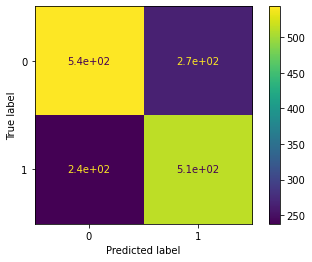

In [52]:
predicted = log_reg_classifier.predict(test_X_tfidf)
print("Accuracy:",accuracy_score(test_y, predicted))
print("Precision:",precision_score(test_y, predicted))
print("Recall:",recall_score(test_y, predicted))

plot_confusion_matrix(log_reg_classifier, test_X_tfidf, test_y)